## Regrid ERA5 files to CRCM5 res05 grid

In [6]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import glob
import time

# my function files
import sys
sys.path.append('/home/portal/script/python/precip_Cristina/')
# sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')
import functions_analogues_PrMax as fanPM

In [18]:
varname = 'msl'
varstr = 'mslp'
data_dir = '/work_big/users/clima/portal/'                  # alice
# data_dir = '/media/alice/Extreme SSD1/folders/data_CNR/'    # tintin
year_range = [2004, 2023]   # for reference climatology
# regridding parameters
box_regridding = [-24.5, 37.5,30.5, 64.5]  # [lon_min, lon_max, lat_min, lat_max]
resolution = 0.5

### File selection

In [19]:
# Define the file pattern
file_pattern = data_dir + 'ERA5/' + varstr + "/ERA5_"+varstr+"_NH_daily_????_anom.nc"
# Get all file paths matching the pattern
all_files = glob.glob(file_pattern)
# Select and sort files
selected_files = []
for year in range(year_range[0], year_range[1]+1):
    selected_files += [file for file in all_files if str(year) in file]
selected_files = sorted(selected_files)
print(selected_files[:5])
print(sorted(all_files)[:5])

['/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_2004_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_2005_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_2006_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_2007_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_2008_anom.nc']
['/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_1985_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_1986_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_1987_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_1988_anom.nc', '/work_big/users/clima/portal/ERA5/mslp/ERA5_mslp_NH_daily_1989_anom.nc']


#### Retrieve Nan mask from CRCM5_LE

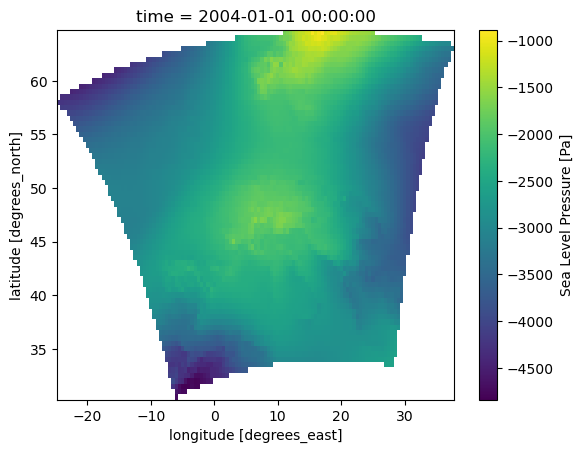

In [20]:
data_CRCM5_LE = xr.open_dataset(data_dir + '/CRCM5-LE/psl/kba/2004/res05/psl-anom_EUR-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_daily_200401_remapbil-to-05res.nc')
data_CRCM5_LE_T0 = data_CRCM5_LE.isel(time=0)
# plot CRCM5_LE T0
data_CRCM5_LE_T0['psl'].plot()
# Get nan mask from CRCM5_LE
nan_mask_CRCM5_LE = data_CRCM5_LE_T0['psl'].isnull()

### Load data and regrid to 0.5 deg resolution

In [ ]:
for iy, year in enumerate(range(year_range[0], year_range[1]+1)):
    print(f"Loading data for year {year}...")
    # Upload data
    data_ERA5 = xr.open_dataset(selected_files[iy])
    # Apply regridding
    data_ERA5_regridded = fanPM.regrid_with_xesmf(data_ERA5[varname], box_regridding, resolution)
    # Set to nan where nan mask is true
    data_ERA5_regridded = data_ERA5_regridded.where(~nan_mask_CRCM5_LE, np.nan)
    # Save to netcdf
    data_ERA5_regridded.to_netcdf(data_dir + 'ERA5/' +  varstr + '/res05/ERA5_'+varstr+'_NH_daily_'+str(year)+'_anom_regridded-to-CRCM5.nc', mode='w', format='NETCDF4', engine='netcdf4')


Loading data for year 2004...
Loading data for year 2005...
Loading data for year 2006...
Loading data for year 2007...
Loading data for year 2008...
Loading data for year 2009...
Loading data for year 2010...
Loading data for year 2011...
Loading data for year 2012...
Loading data for year 2013...
Loading data for year 2014...
Loading data for year 2015...
Loading data for year 2016...
Loading data for year 2017...
Loading data for year 2018...
Loading data for year 2019...
Loading data for year 2020...
Loading data for year 2021...
Loading data for year 2022...
Loading data for year 2023...


In [22]:
# Regrid climatology
data_ERA5 = xr.open_dataset(data_dir + 'ERA5/' + varstr + '/climatology/ERA5_'+varstr+'_NH_daily_clim_'+str(year_range[0])+'-'+str(year_range[1])+'_sm31d.nc')
# Apply regridding
data_ERA5_regridded = fanPM.regrid_with_xesmf(data_ERA5[varname], box_regridding, resolution)
# Set to nan where nan mask is true
data_ERA5_regridded = data_ERA5_regridded.where(~nan_mask_CRCM5_LE, np.nan)
# Save to netcdf
data_ERA5_regridded.to_netcdf(data_dir + 'ERA5/' +  varstr + '/res05/climatology/ERA5_'+varstr+'_NH_daily_clim_'+str(year_range[0])+'-'+str(year_range[1])+'_sm31d_regridded-to-CRCM5.nc', mode='w', format='NETCDF4', engine='netcdf4')